# Calculating yields

In [1]:
from cameo import load_model, fba
model_original = load_model('data/iJO1366.xml.gz')

## Product yield

In [2]:
model = model_original.copy()

Calculating the yield of a product is straigtforward. First one sets the producing reaction a new objective of the model.

In [3]:
model.objective = model.reactions.EX_ac_e

Then one determines the maximum production flux by solving the model.

In [4]:
model.solve()
model.reactions.EX_ac_e.flux

29.093467336683453

Dividing the production flux by the uptake flux of the carbon source (in this case glucose) yields the molar yield (mol product / mol glucose).

In [5]:
model.reactions.EX_ac_e.flux / (-1. * model.reactions.EX_glc__D_e.flux)

2.9093467336683454

## Exercise

* Convert the yield into a C-mol (product) / C-mol (carbon source) yield.
* Calculate a mass yield instead of molar yield (g (product) / g (carbon source))

In [6]:
(model.reactions.EX_ac_e.flux * model.metabolites.ac_c.elements['C']) / (-1. * model.reactions.EX_glc__D_e.flux * model.metabolites.glc__D_e.elements['C'])

0.9697822445561151

In [7]:
(model.reactions.EX_ac_e.flux * model.metabolites.ac_c.formula_weight) / (-1. * model.reactions.EX_glc__D_e.flux * model.metabolites.glc__D_e.formula_weight)

0.9535049687506645

## Biomass yield

In [8]:
model = model_original.copy()

In [9]:
model.solve()
gDW_biomass_per_mmol_glucose = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux / (-1. * model.reactions.EX_glc__D_e.flux)
gDW_biomass_per_mmol_glucose

0.09823718127269808

The units of this yield are gDW (Biomass) / mmol (glucose). We can convert this number into a mass yield by doing the following conversion.

In [10]:
gDW_biomass_per_g_glucose = gDW_biomass_per_mmol_glucose * (1000 / model.metabolites.glc__D_e.formula_weight)
gDW_biomass_per_g_glucose

0.5452898971307408

# Growth vs. Product yield

In [11]:
model = model_original.copy()

In the previous section we calculated theoretical maximum yields in the absence of competing objectives. But how does product yield vary with growth for example?

In [12]:
from numpy import array, linspace

In [13]:
growth_rates = linspace(0, model.solve().objective_value , 10)
growth_rates

array([ 0.        ,  0.10915242,  0.21830485,  0.32745727,  0.43660969,
        0.54576212,  0.65491454,  0.76406697,  0.87321939,  0.98237181])

In [14]:
product_fluxes = []
model.objective = model.reactions.EX_ac_e
for growth in growth_rates:
    model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.change_bounds(growth, growth)
    product_fluxes.append(model.solve().objective_value)
product_fluxes = array(product_fluxes)

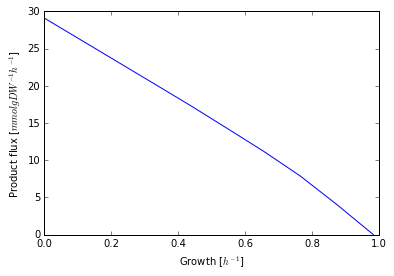

In [15]:
import matplotlib.pyplot as plt
plt.plot(growth_rates, product_fluxes)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()

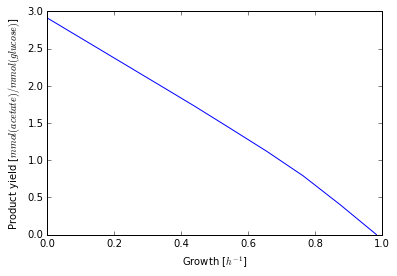

In [16]:
plt.plot(growth_rates, product_fluxes / (-1 * model.reactions.EX_glc__D_e.flux))
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product yield [$mmol(acetate) / mmol(glucose)$]')
plt.show()

Luckily, cameo provides a function for calculating phenotypic planes. For example, let's compute again the phenotypic phase plane for growth and acetate secretion.

In [17]:
from cameo import phenotypic_phase_plane

In [18]:
model = model_original.copy()

In [19]:
result = phenotypic_phase_plane(model,
                                variables=[model.reactions.BIOMASS_Ec_iJO1366_core_53p95M],
                                objective=model.reactions.EX_ac_e)

Look at the result in a tabular view.

In [20]:
result.data_frame

,BIOMASS_Ec_iJO1366_core_53p95M,objective_lower_bound,objective_upper_bound
0,0.000000,0.0,29.093467
1,0.051704,0.0,27.702279
2,0.103408,0.0,26.311092
3,0.155111,0.0,24.919904
...,...,...,...
16,0.827260,0.0,5.753441
17,0.878964,0.0,3.835628
18,0.930668,0.0,1.917814
19,0.982372,0.0,0.000000


Plot the phenotypic phase plane.

In [21]:
result.plot()

/Users/niso/anaconda/envs/cameo3.4/lib/python3.4/site-packages/bokeh/io.py:350: UserWarning:



BokehJS does not appear to have successfully loaded. If loading BokehJS from CDN, this
may be due to a slow or bad network connection. Possible fixes:

* ALWAYS run `output_notebook()` in a cell BY ITSELF, AT THE TOP, with no other code
* re-rerun `output_notebook()` to attempt to load from CDN again, or
* use INLINE resources instead, as so:

    from bokeh.resources import INLINE
    output_notebook(resources=INLINE)




We can also calculate a three dimensional phenotypic phase plane to compare the influence of aerobic and anaerobic environements.

In [22]:
%%time
result_3D = phenotypic_phase_plane(model,
                                   variables=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.BIOMASS_Ec_iJO1366_core_53p95M)

CPU times: user 5.58 s, sys: 52.8 ms, total: 5.64 s
Wall time: 5.91 s


In [23]:
result_3D.data_frame

,EX_ac_e,EX_o2_e,objective_lower_bound,objective_upper_bound
0,0.000000,-310.000000,0.0,0.000000
1,0.000000,-293.684211,0.0,0.377801
2,0.000000,-277.368421,0.0,0.755600
3,0.000000,-261.052632,0.0,0.982372
...,...,...,...,...
396,29.093467,-48.947368,0.0,0.000000
397,29.093467,-32.631579,0.0,0.000000
398,29.093467,-16.315789,0.0,0.000000
399,29.093467,0.000000,0.0,0.000000


Unfortunately, 3D plots are not yet supported out of the box.

In [24]:
result_3D.plot()

NotImplementedError: 

So let's quickly write a custom plot (you can use your mouse to rotate the graphic).

In [27]:
%matplotlib notebook
%matplotlib inline

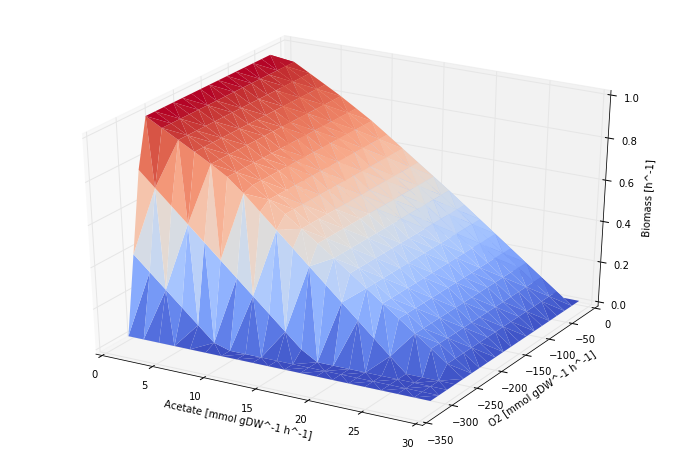

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    result_3D.data_frame.EX_ac_e.values,
    result_3D.data_frame.EX_o2_e.values,
    result_3D.data_frame.objective_upper_bound.values,
    cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('Acetate [mmol gDW^-1 h^-1]')
ax.set_ylabel('O2 [mmol gDW^-1 h^-1]')
ax.set_zlabel('Biomass [h^-1]')
ax.mouse_init()
# interact(f(fig, ax), angle=(0, 360), elevation=(-100, 100))